# Optimization

In [9]:
import modules
from modules import Aqua_Obj
import optimization
import numpy as np
import importlib
importlib.reload(modules)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.filterwarnings('ignore')

max_iter = 2000

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(aqua_obj):
    print(' '*2, "cost_per_yield", "{:10.3f}".format(aqua_obj.cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(aqua_obj.price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(aqua_obj.fish_yield), '[kg]')

def print_ineq_cons(aqua_obj):
    print(' '*2, "P_gen_cons          ", "{:10.3f}".format(aqua_obj.P_gen_cons), '[kWh]')
    print(' '*2, "fish_yield_cons     ", "{:10.3f}".format(aqua_obj.fish_yield_cons), '[kg]')
    print(' '*2, "env_Umin_cons       ", "{:10.3f}".format(aqua_obj.env_Umin_cons), '[m/s]')
    print(' '*2, "env_Umax_cons       ", "{:10.3f}".format(aqua_obj.env_Umax_cons), '[m/s]')
    print(' '*2, "env_tempmin_cons    ", "{:10.3f}".format(aqua_obj.env_tempmin_cons), '[C]')
    print(' '*2, "env_tempmax_cons    ", "{:10.3f}".format(aqua_obj.env_tempmax_cons), '[C]')
    print(' '*2, "env_salinitymin_cons", "{:10.3f}".format(aqua_obj.env_salinitymin_cons), '[PSU]')
    print(' '*2, "env_salinitymax_cons", "{:10.3f}".format(aqua_obj.env_salinitymax_cons), '[PSU]')
    print(' '*2, "env_O2_min_cons     ", "{:10.3f}".format(aqua_obj.env_O2_min_cons), '[mg/l]')
            
def optimize_result(x_name, x_list, x_unit, res, p, opt_idx):
    col_width = len(max(x_list, key=len))
    aqua_opt_obj = Aqua_Obj(res[opt_idx].x, x_name, p) 
    print(res[opt_idx].success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x_unit[i])
    print("-"*40)

    print_bold("optimal objective function terms:")
    print_objective(aqua_opt_obj)
    print("-"*40)
    
    print_bold("optimal constraints:")
    print_ineq_cons(aqua_opt_obj)
    print("-"*40)
    
    
# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','x_disc_pen','p_pen','pos_env','x_env','p_wec','p_fish_salmon']

wec_types = ['point absorber'] #,'attenuator','terminator','point absorber']

# design variables
x_name = ['pos_env']
x_list, x0_val, x_unit, x_bnds, x_label = optimization.default_value(x_name)
x0 = []
for i in range(len(x_list)):
    x0.append(x0_val[x_list[i]])

# parameters
param_name = ['x_type_wec', 'x_wec', 'x_pen','x_disc_pen']
param_val = {}
# WEC and Pen Parameters are defined by optimal results obtained by running "run_sim_wec" 
param_val['capture_width']=  3.65  #[m]
param_val['pen_diameter']=   14.84  #[m]
param_val['pen_height']=     3.042   #[m]
param_val['spacing']=        150     #[m]
param_val['stock_density']=  30      #[kg/m^3]
param_val['pen_depth']=      10.63      #[m]
param_val['num_pens']=       6

#optimization
best_idx = 0
res={}

for i in range(len(wec_types)):
    param_val['wec_type'] = wec_types[i]
    p_list, p, p_unit, p_bnds, p_label = optimization.argument_fun(x_name, param_name, param_val, all_vars)
    
    aqua_init_obj = Aqua_Obj(x0, x_name, p) 
    print_bold("Initial objective function terms:")    
    print_objective(aqua_init_obj)
    print_bold("Initial constraints:")
    print_ineq_cons(aqua_init_obj)
    print('+'*40)
    
    res[i], op_obj = optimization.run_optimization(x_name, x0, param_name, param_val, all_vars, max_iter)
    

    if res[i].fun < res[best_idx].fun:
        best_idx = i

optimize_result(x_name, x_list, x_unit, res, p, best_idx)

Initial objective function terms:
   cost_per_yield      7.008 [$/kg]
   price          564148.458 [$]
   fish_yield      80502.307 [kg]
Initial constraints:
   P_gen_cons           108775.530 [kWh]
   fish_yield_cons      366031.958 [kg]
   env_Umin_cons             0.028 [m/s]
   env_Umax_cons             1.962 [m/s]
   env_tempmin_cons          8.766 [C]
   env_tempmax_cons         17.234 [C]
   env_salinitymin_cons      1.834 [PSU]
   env_salinitymax_cons      3.166 [PSU]
   env_O2_min_cons           4.922 [mg/l]
++++++++++++++++++++++++++++++++++++++++
True
optimal design variable:
   pos_x     -70.000 m
   pos_y      41.000 m
----------------------------------------
optimal objective function terms:
   cost_per_yield      7.008 [$/kg]
   price          564148.458 [$]
   fish_yield      80502.307 [kg]
----------------------------------------
optimal constraints:
   P_gen_cons           108775.530 [kWh]
   fish_yield_cons      366031.958 [kg]
   env_Umin_cons             0.028 [m/s

# Plot fish growth and fish oxygen demand

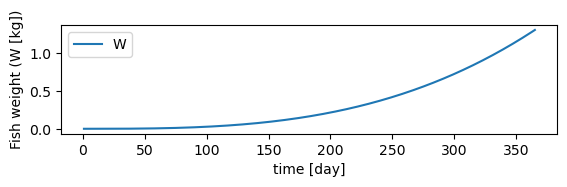

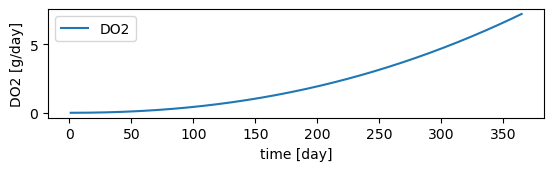

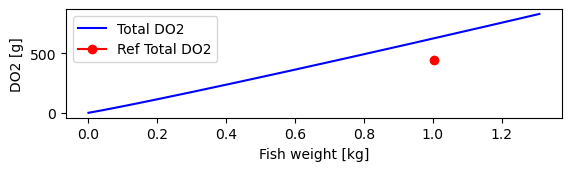

DO2 for 1kg fish 591.7028507712805
DO2 for 2kg fish 0
DO2 for 3kg fish 0
DO2 for 4kg fish 0
fish weight after 365 days 1309.183212127668


In [10]:
aqua_opt_obj = Aqua_Obj(res[best_idx].x, x_name, p) 
aqua_opt_obj.plot_variable()

# Plot objective function and constraints

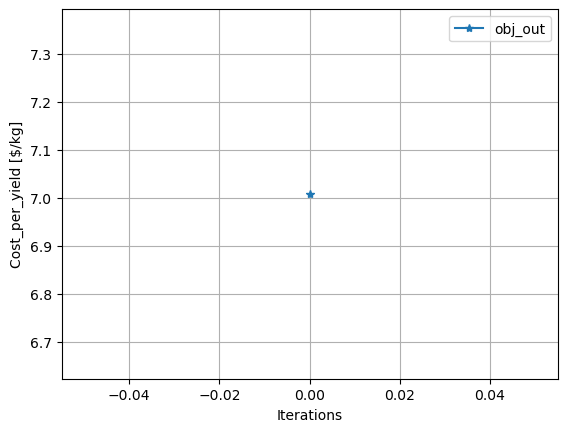

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(op_obj.f, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)
plt.show()

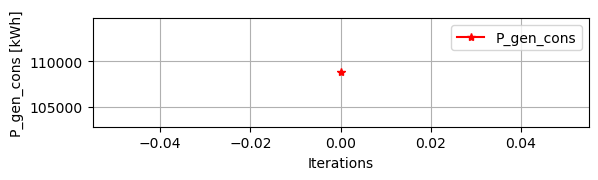

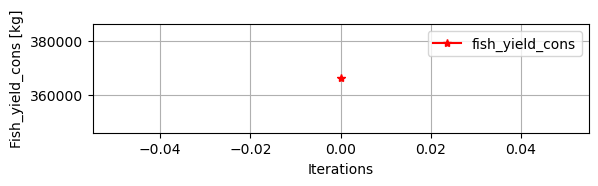

In [12]:
ax1 = plt.subplot(3,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', label='P_gen_cons', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax1.legend()
ax1.grid(True)
plt.show()

ax2 = plt.subplot(3,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', label='fish_yield_cons', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax2.legend()
ax2.grid(True)
plt.show()
